In [1]:
%matplotlib inline

import seaborn as sns
from jupyterthemes import jtplot

cmap = sns.dark_palette('azure', input='xkcd')
jtplot.style()

In [2]:
import numpy as np
from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.preprocessing import normalize
from ot import emd2

def floyd(mt):
    return graph_shortest_path(mt, False, 'auto')

def get_curvature(mt, threshold=0):
    n = len(mt)
    ab = np.abs(mt)
    hop = floyd(ab > threshold)
    piles = normalize(ab, 'l1')
    res = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if hop[i, j] > 0:
                res[i, j] = 1 - emd2(piles[i], piles[j], hop) / hop[i, j]
    return res

In [3]:
from concurrent.futures import ThreadPoolExecutor

def work(patient, i):
    res = patient.result()
    print('done patient {}'.format(i))
    return res

def curvate(timestamp, i, j):
    res = get_curvature(timestamp)
    print('done timestamp {} of patient {}'.format(j, i))
    return res

def process(patient, i):
    return [ curvate(timestamp, i, j) for j, timestamp in enumerate(patient) ]

try:
    with np.load('intime.npz') as dct:
        curv = [dct['ctrl'], dct['ptnt']]
except:
    curv = []
    for a in ['controls', 'patients']:
        ndarr = np.load('data/AD_'+a+'_corr_mats_intime/'+a+'_all_intime.npy')
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(process, pt, i) for i, pt in enumerate(ndarr)]
            curv.append(np.array([work(future, i) for i, future in enumerate(futures)]))
    np.savez('intime.npz', ctrl=curv[0], ptnt=curv[1])

In [4]:
import pandas as pd

labels = pd.read_csv('labels.csv')
labels

,x,y,z,name,net name
0,-53.28,-8.88,32.36,L Aud,Aud
1,53.47,-6.49,27.52,R Aud,Aud
2,1.18,-74.54,10.79,Striate,Striate
3,-45.80,-64.78,31.84,L DMN,DMN
4,-0.20,-55.21,29.87,Med DMN,DMN
5,-0.15,51.42,7.58,Front DMN,DMN
6,51.66,-59.34,28.88,R DMN,DMN
7,0.41,-91.05,1.58,Occ post,Occ post
8,-1.48,-27.93,61.50,Motor,Motor
9,40.10,20.96,44.72,R DLPFC,R V Att


In [5]:
nonzero = [x[(x != 0).any(3).any(2).all(1), :, :, :] for x in curv]
curvature = np.concatenate(nonzero)
y = np.concatenate([[i] * len(x) for i, x in enumerate(nonzero)])
vertex_curvature = curvature.mean(axis=3)
C = np.where(y == 0, 'r', 'b')

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def show_accuracy(y_test, y_pred):
    print('Точность: ', round(accuracy_score(y_test, y_pred), 3))
    conf_mt = confusion_matrix(y_test, y_pred)
    labels = ['CTL', 'PNT']
    ax = plt.subplot()
    sns.heatmap(conf_mt, annot=True, ax=ax, cmap=cmap)
    ax.set_xlabel('Предсказание')
    ax.set_ylabel('На самом деле')
    ax.set_title('Ошибки')
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels, rotation=360)
    plt.show()

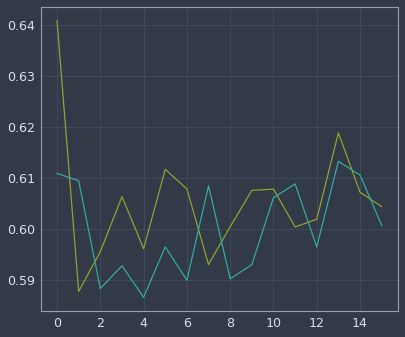

In [7]:
dmn = labels.index[labels['net name'] == 'DMN'].tolist()
X = vertex_curvature[:, :, dmn].mean(2)
X1 = vertex_curvature.mean(2)
pal = sns.color_palette('husl', 4)
plt.plot(X[y == 0].mean(0), c=pal[1])
plt.plot(X[y == 1].mean(0), c=pal[2])
plt.show()

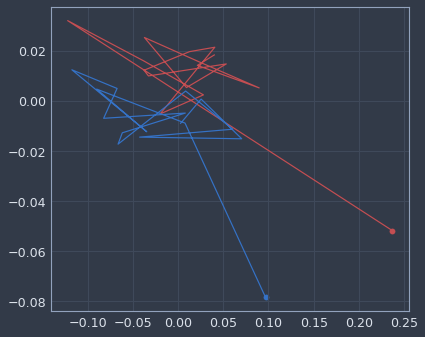

In [8]:
from sklearn.decomposition import PCA

flat = vertex_curvature.reshape((-1, vertex_curvature.shape[-1]))
tf = PCA().fit(flat)
Xc = tf.transform(vertex_curvature[y==0].mean(0))
Xp = tf.transform(vertex_curvature[y==1].mean(0))
plt.plot(Xc[:, 0], Xc[:, 1], c='r')
plt.scatter(Xc[0, 0], Xc[0, 1], c='r')
plt.plot(Xp[:, 0], Xp[:, 1], c='b')
plt.scatter(Xp[0, 0], Xp[0, 1], c='b')
plt.show()

In [9]:
from sklearn.feature_selection import chi2

sh = vertex_curvature.shape
X = PCA(n_components=10).fit_transform(vertex_curvature.reshape((sh[0], -1))) ** 2
chi2(X, y)[1]

array([0.4464301 , 0.28312949, 0.53369047, 0.11096347, 0.09502256,
       0.66938331, 0.79735459, 0.95175253, 0.63891834, 0.84844946])

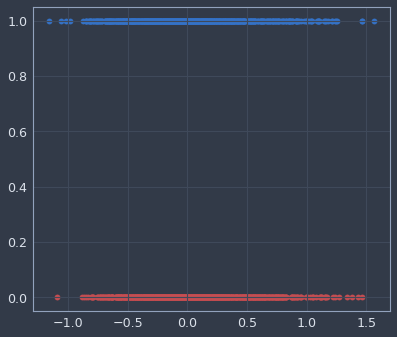

In [10]:
sh = vertex_curvature.shape
X0 = PCA().fit_transform(vertex_curvature.reshape((-1, sh[-1]))).reshape(sh)
X = X0[:, :, 0] + X0[:, :, 1]
for x, yy, c in zip(X, y, C):
    plt.scatter(x, np.ones(len(x)) * yy, c=c)
plt.show()

In [ ]:
from numpy.linalg import norm

ymin = vertex_curvature.min()
ymax = vertex_curvature.max()
dmn = labels.index[labels['net name'] == 'DMN'].tolist()
palette = sns.color_palette('husl', len(dmn))
for x, kind in zip(vertex_curvature, y):
    mean = x[:, dmn].mean(axis=1)
    plt.plot(mean, c='white')
    for i, ind in enumerate(dmn):
        curve = x[:, ind]
        plt.plot(curve, c=palette[i], label=labels['name'][ind] + ' ' + str(norm(curve - mean)))
    plt.gca().set_ylim([ymin, ymax])
    plt.legend()
    plt.title('Control' if kind == 0 else 'Patient')
    plt.show()

In [ ]:
palette = sns.color_palette("husl", vertex_curvature.shape[2])
ymin = vertex_curvature.min()
ymax = vertex_curvature.max()
for x, kind in zip(vertex_curvature, y):
    for curve, color in zip(x, palette):
        plt.plot(curve, c=color)
    plt.gca().set_ylim([ymin, ymax])
    plt.title('Control' if kind == 0 else 'Patient')
    plt.show()

Точность:  0.683


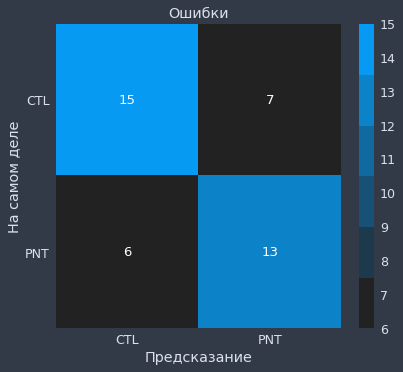

In [134]:
from sklearn.preprocessing import StandardScaler

def prep(src):
    sc = StandardScaler().fit(src.mean(2)).transform
    return lambda x: sc(x.mean(2))

X_tr, X_ts, Y_tr, Y_ts = train_test_split(vertex_curvature, y, test_size=0.3)
X = prep(X_tr)
X_tr = X(X_tr)
X_ts = X(X_ts)
clf = LogisticRegression().fit(X_tr, Y_tr)
Y_pred = clf.predict(X_ts)
show_accuracy(Y_ts, Y_pred)